# <font color=seagreen>Adaptive MCMC</font>
This notebook will contain the overall sequence of our project

## <font color= navy> Part 1 : Optimal Scaling for a Random Walk Metropolis-Hastings Algorithm</font>
We need to choose the correct value of h to get good exploration as well as good acceptance probability.

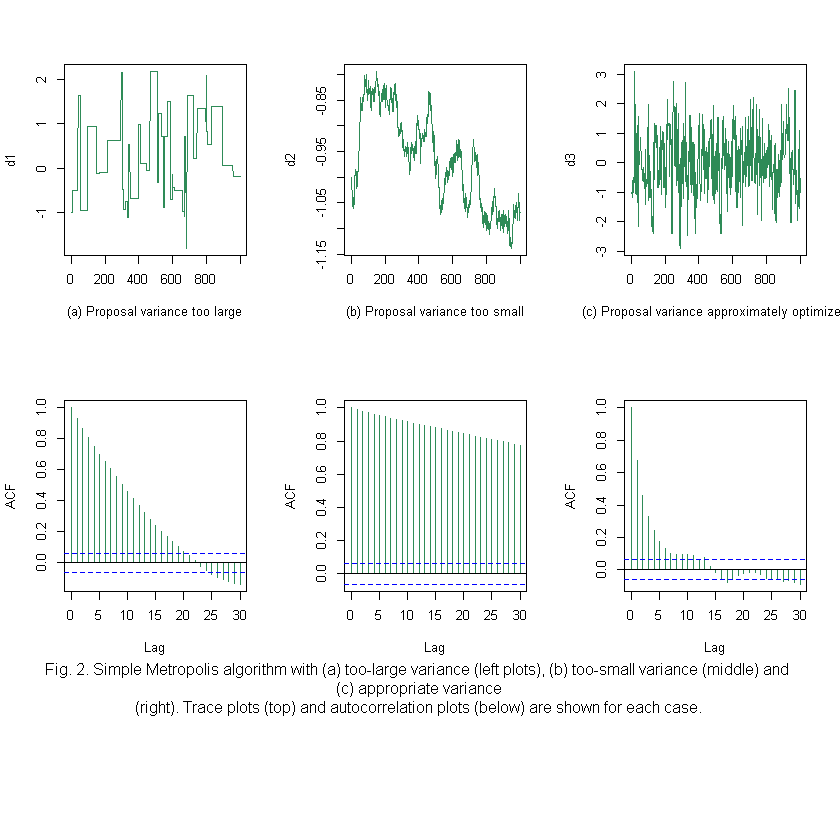

In [9]:
## optimal scaling and motivation for adaptive mcmc
set.seed(1011) # for reproducibility

# target - N(0,1)
# proposal - N(x,h) where h is to be chosen

N <- 1e5  # length of the chain

rwmh <- function(N=1e3,h){
    X <- numeric(N) # creating MC
    X <- -1 # starting value
    p <- 0 # for calculating acc. prob.
    # implementing RWMH
    for(i in 2:N)
    {
     Y <- rnorm( 1 , mean = X[i-1] , sd = sqrt(h) )
     if( runif(1) < dnorm(Y)/dnorm(X[i-1]) ) 
     {
      X[i] <- Y
      p <- p+1
      } else {
      X[i] <- X[i-1]
     }
    } 
    return( list(acc.prob=p/N, chain=X) )
}

# plots

#par(mfrow=c(2,3))
layout(matrix(c(1,2,3,4,5,6,7,7,7), ncol=3, byrow=TRUE), heights=c(2,2,1))
plot.ts(rwmh(h=1000)$chain,col="seagreen",
xlab="(a) Proposal variance too large",ylab="d1")
ts.plot(rwmh(h=0.0001)$chain,col="seagreen",
xlab="(b) Proposal variance too small",ylab="d2")
ts.plot(rwmh(h=2)$chain,col="seagreen",
xlab="(c) Proposal variance approximately optimized",ylab="d3")
acf(rwmh(h=1000)$chain,col="seagreen",main="")
acf(rwmh(h=0.0001)$chain,col="seagreen",main="")
acf(rwmh(h=2)$chain,col="seagreen",main="")

title("Fig. 2. Simple Metropolis algorithm with (a) too-large variance (left plots), (b) too-small variance (middle) and \n(c) appropriate variance
(right). Trace plots (top) and autocorrelation plots (below) are shown for each case.",
line = -45, outer = TRUE,font.main=1)

## <font color=navy>Part 2 : Adaptive MH</font>
Although doing optimal scaling by hit-and-trial is feasible in one-dimension, it can become increasingly difficult in higher dimesions as expected. We have already seen this hands-on while doing the HW problems in our course MTH707A : MCMC .
One approach is to let the MCMC algorithm adapt - i.e. learn by itself what can be the suitable parameters. 
As an example, below we see thr adpative MH for an ill-conditioned variance-covarinace matrix for a multivariate normal distributuion with mean 0.

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"

Time difference of 11.89264 mins

The acceptance probability is:  0.07298

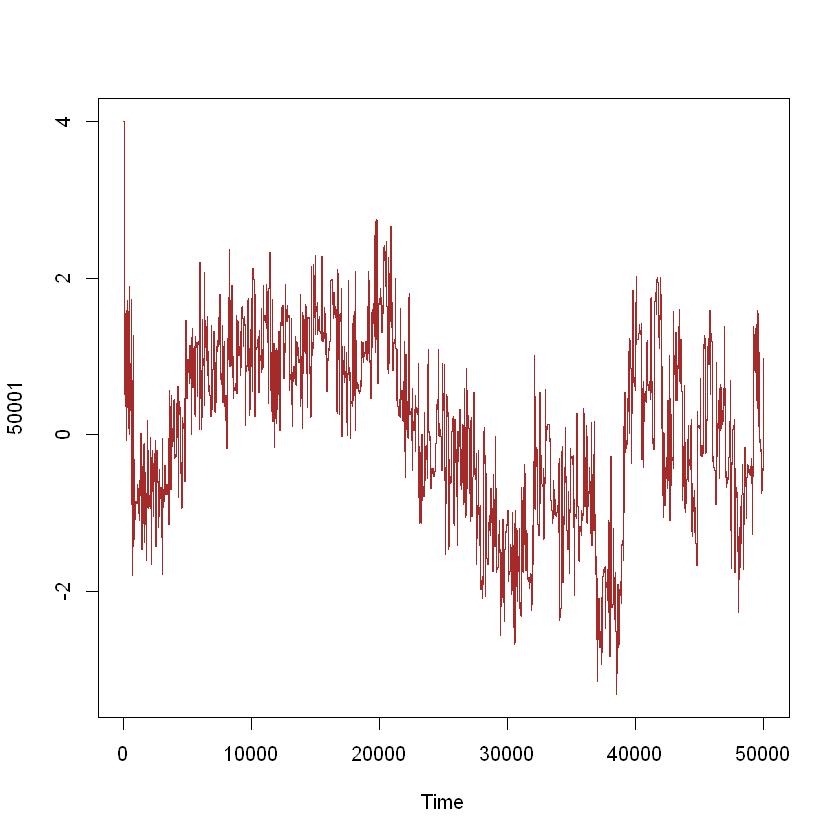

In [4]:
start <- Sys.time()
set.seed(1011) # for reproducibility
library(mvtnorm) # to deal with multivariate normal distribution
# library(clusterGeneration) # to help generate the variance-covarinace matrix using eigen values

d <- 4 # dimension
N <- 5e4 # length of MC
X <- matrix(d,nrow=N+1,ncol=d)


# generating a Sigma for the target distribution
#eig <- seq(1,1e1,length=d) 
#Sigma <- genPositiveDefMat(dim=d,covMethod="eigen",eigenvalue=eig)$Sigma 
M <- matrix(rnorm(d*d),nrow=d)
Sigma <- M%*%t(M)

# target - N_10(mean=0, var= Sigma)

beta <- .05
p=0 # for calculating acceptance probability

# implementing the adaptive MH
Sigma_n <- cov(X)
for(i in 3:(N+1))
{
 # print(i)
 Sigma_n <- (i-2)/(i-1)*Sigma_n + 1/(i)*as.matrix(apply(X[1:(i-1),],2,mean)%*%t(apply(X[1:(i-1),],2,mean))-
                                       (X[i,])%*%t(as.matrix(apply(X[1:(i-1),],2,mean)))-
                                       as.matrix(apply(X[1:(i-1),],2,mean))%*%t(X[i,])+X[i,]%*%t(X[i,]))
 # proposing
 if (i<=2*d) 
     {
     Y<- rmvnorm( n = 1 , mean = X[i-1,] , sigma = 0.1^2/d*diag(d) )
     } else {    
 if( rbinom( n = 1 , size = 1 , prob = beta) ){ 
 Y<- rmvnorm( n = 1 , mean = X[i-1,] , sigma = 0.1^2/d*diag(d) )
 } else {
 Y<- rmvnorm( n = 1 , mean = X[i-1,] , sigma = 2.38^2/d*Sigma_n )  
        }
            }
 Y <- as.vector(Y)
 U <- runif(1)
 r <- dmvnorm( Y , mean = rep(0,d) , sigma = Sigma )/dmvnorm( X[i-1,] , mean = rep(0,d) , sigma = Sigma)  
 if ( U < r )
 {
  X[i,] <- Y
  p <- p+1
 } else{
  X[i,] <- X[i-1,]
       }
}
Sys.time()-start
cat("The acceptance probability is: ",p/N)
#par(mfrow=c(2,1),bg="pink") 
ts.plot(X[,3],ylab=i,col="brown")
# acf(X[,3],ylab=i,col="blue",main="")


## <font color=navy> Adaptive portkey in Gamma mixture of Weibulls</font>
Here, the power of adaptive MCMC is not revealed as it is a one-dimensional problem. 

The acceptance probability for MCA at beta= 0.99 is 0.551 
The acceptance probability for MCNA at beta= 0.99 is 0.4562 
The acceptance probability for MCA at beta= 0.90 is 0.3323 
The acceptance probability for MCNA at beta= 0.90 is 0.2748 
The acceptance probability for MCA at beta= 0.75 is 0.2005 
The acceptance probability for MCNA at beta= 0.75 is 0.1679 


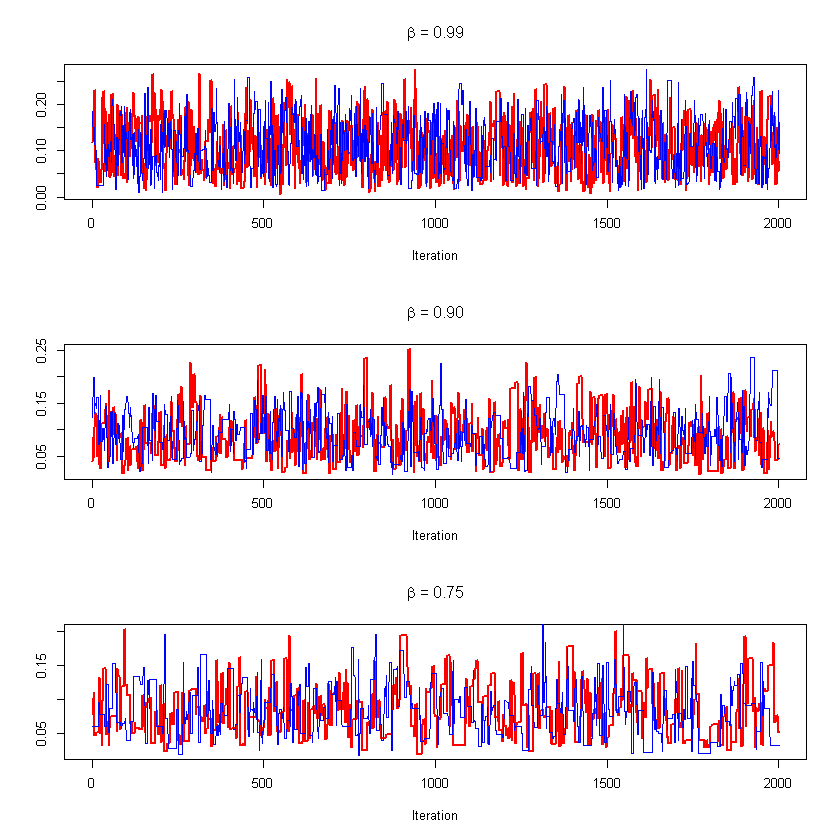

In [3]:
set.seed(1011) # for reproducibility

### portkey 2-coin algorithm
p2c <- function(beta=0.75,x,y,k=10)
{
 while(1){
 S <- rbinom(n = 1, size = 1, prob = beta)
 if (S==0) return(0)
 if (S==1)
 {
  C1 <- rbinom(n = 1, size = 1, prob = x/(x+y) )
  if (C1==1)
  {
   C2 <- ifelse(runif(1)<(dweibull(y, scale=rgamma(1,10,100),shape=k)/(k/exp(1)*y)),1,0)
   if (C2==1) {
    return(1) } else (next)
  }
 }
  else
  {
   C2 <- ifelse(runif(1)<(dweibull(x, scale=rgamma(1,10,100),shape=k)/(k/exp(1)*x)),1,0)
   if (C2==1) {
	return(0) } else (next)
  }
         }
}

## MC function for adaptive portkey
# X for adaptive

# beta---0.05 (for adaptive MCMC)

MCA <- function(N=1e4,b=0.75){
X <- numeric(N) # creating  the MC
X[1] <- .1

p=0 # adaptive 
for (i in 2:N)
{ #print(i)
 Sigma_n <- (N-1)/N*var(X)
# Y <- ifelse(rbinom(n=1,size=1,prob=0.05),rnorm(n=1,mean=X[i-1],sd=0.1),
 #            rnorm(n=1,mean=X[i-1],sd=sqrt(2.38^2*Sigma_n)))

 if (i<=2) 
     {
     Y<- rnorm( n = 1 , mean = X[i-1] , sd =0.1 )
     } else {    
 if( rbinom( n = 1 , size = 1 , prob = b) ){ 
 Y<- rnorm( n = 1 , mean = X[i-1] , sd = 0.1 )
 } else {
 Y<- rnorm( n = 1 , mean = X[i-1] , sd = sqrt(2.38^2*Sigma_n) )  
        }
            }

 if (Y<0) {
 X[i] <- X[i-1]
 next }
 if(p2c(x=X[i-1],y=Y,beta=b))
 {
  X[i] <- Y
  p <- p+1
 } else{
 X[i] <- X[i-1]
       } 
}
 return (list("chain"=X,"acc.prob" =p/N))
}

## MC function for non-adaptive portkey

MCNA <- function(N=1e4,b=0.75){
Z <- numeric(N) # creating  the MC
Z[1] <- .1

p=0 # adaptive 
for (i in 2:N)
{ #print(i)
 Y <- rnorm(1,mean=Z[i-1],sd=0.13)
 if (Y<0) {
 Z[i] <- Z[i-1]
 next }
 if(p2c(x=Z[i-1],y=Y,beta=b))
 {
  Z[i] <- Y
  p <- p+1
 } else{
 Z[i] <- Z[i-1]
       } 
}
 return (list("chain"=Z,"acc.prob"=p/N))
}


par(mfrow=c(3,1))

A <- MCA(b=0.99)
B <- MCNA(b=0.99)

cat("The acceptance probability for MCA at beta= 0.99 is",A$acc.prob,"\n")
ts.plot(A$chain[.8e4:1e4],lwd=2,
xlab="Iteration",col="red",ylab="",
main=expression(paste(beta," = 0.99")))
cat("The acceptance probability for MCNA at beta= 0.99 is",B$acc.prob,"\n")
lines(B$chain[.8e4:1e4],
xlab="Iteration",col="blue",ylab="",
main=expression(paste(beta," = 0.99")))

A <- MCA(b=0.90)
B <- MCNA(b=0.90)

cat("The acceptance probability for MCA at beta= 0.90 is",A$acc.prob,"\n")
ts.plot(A$chain[.8e4:1e4],lwd=2,
xlab="Iteration",col="red",ylab="",
main=expression(paste(beta," = 0.90")))
cat("The acceptance probability for MCNA at beta= 0.90 is",B$acc.prob,"\n")
lines(B$chain[.8e4:1e4],
xlab="Iteration",col="blue",ylab="",
main=expression(paste(beta," = 0.90")))

A <- MCA(b=0.75)
B <- MCNA(b=0.75)

cat("The acceptance probability for MCA at beta= 0.75 is",A$acc.prob,"\n")
ts.plot(A$chain[.8e4:1e4],lwd=2,
xlab="Iteration",col="red",ylab="",
main=expression(paste(beta," = 0.75")))
cat("The acceptance probability for MCNA at beta= 0.75 is",B$acc.prob,"\n")
lines(B$chain[.8e4:1e4],
xlab="Iteration",col="blue",ylab="",
main=expression(paste(beta," = 0.75")))